# Analysis deep layer optogenetics 4 - LFP

In [12]:
# works with saved datasets from deep_layer_stimulus_2

In [13]:
# the following two lines indicate that external functions are auto-reloaded as soon as they change. 
%load_ext autoreload
%autoreload 2
# Print statements 
from __future__ import print_function # Python 2.x

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# General stuff:
import sys
import argparse
import os
import json
import numpy as np
import math
import psycopg2
import cPickle
import pandas as pd
import h5py

from scipy.signal import spectrogram,welch,detrend,butter,filtfilt,hilbert,savgol_filter

pd.options.mode.chained_assignment = None  # default='warn'

from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
from IPython.display import display, HTML

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *
from postgres_analysis_helpers.general import *
from analysis_helpers.misshapen import shape, nonshape

# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

In [15]:
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Yippiyeah! Database connection is established!')

Connecting to the PostgreSQL database...
Yippiyeah! Database connection is established!


In [16]:
# load the parameters to connect to data_1 
params = config()

## Analysis

Retrieve stimulus table for deep layer mice (**retro-cre**, **DIOCheta injections**)

In [17]:
salt_i_thresh = .1
salt_p_thresh = .05
inhib_p_thresh = .001 # arbitrary at the moment!

### Retrieve the stuff:

In [18]:
export_path_pickle  = r"C:\work\python\klusta_analysis\postgres_notebooks\export_dataframes"
export_path_pickle = "/".join(export_path_pickle.split("\\"))

In [19]:
# retrieve:
deep_layer_exc_filtered = pd.read_pickle(export_path_pickle + "/deep_layer_exc_filtered.pkl")
deep_layer_inhib_filtered = pd.read_pickle(export_path_pickle + "/deep_layer_inhib_filtered.pkl")
deep_layer_rest_filtered = pd.read_pickle(export_path_pickle + "/deep_layer_rest_filtered.pkl")

#autocorr_cells = pd.read_pickle(export_path_pickle + "/autocorr_cells.pkl")
#ratemaps_cells = pd.read_pickle(export_path_pickle + "/ratemaps_cells.pkl")
#obj_ratemaps_cells = pd.read_pickle(export_path_pickle + "/obj_ratemaps_cells.pkl")
#bnt_scores_cells = pd.read_pickle(export_path_pickle + "/bnt_scores_cells.pkl")
#spiketimes_tracking_cells = pd.read_pickle(export_path_pickle + "/spiketimes_tracking_cells.pkl")
#obj_spiketimes_tracking_cells = pd.read_pickle(export_path_pickle + "/obj_spiketimes_tracking_cells.pkl")
#tracking_cells = pd.read_pickle(export_path_pickle + "/tracking_cells.pkl")
#obj_tracking_cells = pd.read_pickle(export_path_pickle + "/obj_tracking_cells.pkl")

lfp_cells_deep = pd.read_pickle(export_path_pickle + "/lfp_cells.pkl")

In [20]:
# also retrieve LFP data from superficial MEC mice (Dave's arch mice)
sup_layer_inhib_filtered = pd.read_pickle(export_path_pickle + "/sup_layer_inhib_filtered.pkl")
lfp_cells_sup = pd.read_pickle(export_path_pickle + "/lfp_cells_superficial.pkl")

### Show a quick overview over arch mice ... 

In [21]:
## initialize figure parameters ... 
#if len(sup_layer_inhib_filtered) > 25: 
#    number_plots = 25
#else:
#    number_plots = len(deep_layer_inhib_filtered)
#layout_plots = [5,5]  
#create_spike_plots_stimulus(sup_layer_inhib_filtered,number_plots,layout_plots)

### Work with LFP data

lfp_cells_deep consists of ([deep_layer_exc_filtered,deep_layer_inhib_filtered,deep_layer_rest_filtered])

In [22]:
len(lfp_cells_deep)

390

In [23]:
lfp_cells_deep.head(2)

,cluster_no,analysis_ts,tetrode_no,session_name,filename,n_drive_user,animal_id,session_ts,analysis_window,salt_window,...,inhib_lowest_p,inhib_lowest_p_interval,change_point_ms,spiketimes_cluster,stimulus_timepoints,sum_1ms,bin_edges_1ms,binnumber_1ms,lfp_session,theta_freq
0,39,2017-04-13 15:57:25.511000,8,25032017laser3s1,N:/horsto/71461/25032017/KLUSTA/3.kwik,horsto,71461,2017-03-25 16:59:44,200,10,...,NaN,NaN,NaN,"[1255.6875, 5817.10416667, 9717.08333333, 1726...","[1803466.5, 1803516.5625, 1803566.5625, 180361...","[0.0, 10.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 48.0, 96.0, 144.0, 192.0, 240.0, 288.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",time eeg0 eeg1 eeg2 eeg3 eeg_...,9.166667
0,47,2017-04-13 14:50:36.301000,8,24032017laser3s2,N:/horsto/71461/24032017s2/KLUSTA/3.kwik,horsto,71461,2017-03-24 18:03:23,200,10,...,0.503631,10,NaN,"[3847.0, 8717.72916667, 9351.9375, 11384.0, 12...","[1200079.625, 1202178.8125, 1202278.8125, 1202...","[0.0, 7.0, 53.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[0.0, 48.0, 96.0, 144.0, 192.0, 240.0, 288.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",time eeg0 eeg1 eeg2 eeg3 eeg_...,9.166667


lfp_cells_sup consists of ([sup_layer_inhib_filtered,sup_layer_rest_filtered]), whereby rest also has a filtering for inhibited!

In [24]:
lfp_cells_sup.head(2)

,cluster_no,analysis_ts,tetrode_no,session_name,filename,n_drive_user,animal_id,session_ts,analysis_window,salt_window,...,inhib_lowest_p,inhib_lowest_p_interval,change_point_ms,spiketimes_cluster,stimulus_timepoints,sum_1ms,bin_edges_1ms,binnumber_1ms,lfp_session,theta_freq
0,34,2017-04-09 17:17:31.745000,8,25012017laserSess2,N:/davidcr/70114/25012017/KLUSTA/3.kwik,davidcr,70114,2017-01-25 16:21:05,200,10,...,1.97825e-14,40,2.16667,"[122.479166667, 1993.08333333, 2116.58333333, ...","[2401149.0, 2401443.75, 2401738.5, 2402033.25,...","[48.0, 43.0, 55.0, 39.0, 43.0, 38.0, 47.0, 47....","[0.0, 48.0, 96.0, 144.0, 192.0, 240.0, 288.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",time eeg0 eeg1 eeg2 eeg3 eeg_...,9.0
0,43,2017-04-09 18:06:12.002000,6,01022017laserSess2,N:/davidcr/70114/01022017/KLUSTA/1.kwik,davidcr,70114,2017-02-01 15:25:45,200,10,...,3.15183e-14,40,1.58333,"[1756.5, 1808.27083333, 1894.79166667, 1970.5,...","[2601105.0625, 2601379.5625, 2601674.3125, 260...","[27.0, 21.0, 15.0, 20.0, 16.0, 16.0, 26.0, 27....","[0.0, 48.0, 96.0, 144.0, 192.0, 240.0, 288.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",time eeg0 eeg1 eeg2 eeg3 eeg_...,9.1


In [25]:
len(lfp_cells_sup)

38

In [26]:
# prepare for plotting
label = {0: 'Deep L'}
lfp_cells_deep['all'] = np.zeros((len(lfp_cells_deep))) # generic column if you want to plot seaborn summary over all animals 
lfp_cells_deep['all']= lfp_cells_deep['all'].map(label)
label = {0: 'L2'}
lfp_cells_sup['all'] = np.zeros((len(lfp_cells_sup))) 
lfp_cells_sup['all']= lfp_cells_sup['all'].map(label)

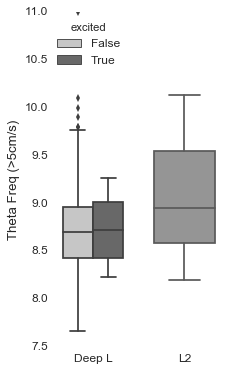

In [27]:
figure = plt.figure(figsize=(3,6))
sns.set(font_scale=1.2)
sns.set_style('white')
counter_fig = 1
ax = figure.add_subplot(1,2,1)
sns.boxplot(x='all', y='theta_freq', hue="excited",
     data=lfp_cells_deep, palette="Greys",ax=ax)
ax.set_ylabel('Theta Freq (>5cm/s)')
ax.set_ylim(7.5,11)
ax.set_xlabel('')

ax = figure.add_subplot(1,2,2)
sns.boxplot(x='all', y='theta_freq',
     data=lfp_cells_sup, palette="Greys",ax=ax)
sns.despine(left=True,bottom=True)
ax.set_ylim(7.5,11)
ax.set_ylabel('')
ax.set_xlabel('')
ax.get_yaxis().set_ticks([])

sns.despine(left=True,bottom=True)
figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=0.9)
plt.show()

### Extract PSDs and Theta peak from PSD

I need to filter the deep layer LFP Dataframe for the excited cells - that label is maintained. 

In [28]:
speed_cutoff = 5.
sample_rate_eeg = 250.
theta_range =(4,15)

### get chunks of datasets to analyze

In [29]:
lfp_cells_deep_excited = lfp_cells_deep[lfp_cells_deep.excited == True]
lfp_cells_deep_excited.reset_index(inplace=True,drop=True)

lfp_cells_deep_inhibited = lfp_cells_deep[lfp_cells_deep.inhibited == True]
lfp_cells_deep_inhibited.reset_index(inplace=True,drop=True)

lfp_cells_sup_inhibited = lfp_cells_sup[lfp_cells_sup.inhibited == True]
lfp_cells_sup_inhibited.reset_index(inplace=True,drop=True)

### concatenate values that you calculate

In [30]:
columns = ['f_speed','psd_speed','theta_peak_freq_speed','theta_peak_pow_speed',
                                                'f_slow', 'psd_slow', 'theta_peak_freq_slow', 'theta_peak_pow_slow',
                                                'rises_speed','decays_speed', 'ratios_speed',
                                                'rises_slow', 'decays_slow', 'ratios_slow']

In [31]:
lfp_deep_exc_analysis = pd.DataFrame(columns=columns)
lfp_deep_inhib_analysis = pd.DataFrame(columns=columns)

lfp_sup_inhib_analysis = pd.DataFrame(columns=columns)

#### first excited (deep layer)

In [32]:
skipped_eegs = 0

# start loop here!
for no in tqdm_notebook(xrange(len(lfp_cells_deep_excited))):
    # extract EEG dataframe:
    eeg_df_session = lfp_cells_deep_excited.iloc[no].lfp_session

    # get theta peak freq > SPEED CUTOFF:
    f_speed, psd_speed = welch(eeg_df_session['eeg_mean'][eeg_df_session['speed']>speed_cutoff], sample_rate_eeg, nperseg=sample_rate_eeg*4)
    theta_peak_freq_speed = f_speed[np.argmax(f_speed==theta_range[0])+np.argmax(psd_speed[(f_speed>=theta_range[0]) & (f_speed<=theta_range[1])])]
    #print('Theta peak freq running: {:.2f} Hz'.format(theta_peak_freq_speed))
    # get theta peak power:
    theta_peak_pow_speed = psd_speed[np.argmax(f_speed==theta_range[0])+np.argmax(psd_speed[(f_speed>=theta_range[0]) & (f_speed<=theta_range[1])])]
    #print('Theta peak power speed: {:.2f}'.format(theta_peak_pow_speed))

    # get theta peak freq < SPEED CUTOFF:
    f_slow, psd_slow = welch(eeg_df_session['eeg_mean'][eeg_df_session['speed']<speed_cutoff], sample_rate_eeg, nperseg=sample_rate_eeg*4)
    theta_peak_freq_slow = f_slow[np.argmax(f_slow==theta_range[0])+np.argmax(psd_slow[(f_slow>=theta_range[0]) & (f_slow<=theta_range[1])])]
    #print('Theta peak freq slow: {:.2f} Hz'.format(theta_peak_freq_slow))
    # get theta peak power:
    theta_peak_pow_slow = psd_slow[np.argmax(f_slow==theta_range[0])+np.argmax(psd_slow[(f_slow>=theta_range[0]) & (f_slow<=theta_range[1])])]
    #print('Theta peak power slow: {:.2f}'.format(theta_peak_pow_slow))
   
    # rise decay ratios...

    # > SPEED CUTOFF
    x = eeg_df_session['eeg_mean'].values[eeg_df_session['speed'] > speed_cutoff]
    Ps, Ts = nonshape.findpt(x, theta_range, boundary=sample_rate_eeg, Fs=sample_rate_eeg,forcestart = 'trough') # Find peaks and troughs
    rises_speed = []
    decays_speed = []
    ratios_speed = []
    for no in xrange(int(len(Ts)-sample_rate_eeg)): # - Fs as safety boundary
        if (Ps[no] < Ts[no+1]) and (Ps[no] > Ts[no]):
            rises_speed.append(Ps[no]-Ts[no])
            decays_speed.append(Ts[no+1]-Ps[no])
            ratios_speed.append(float(Ps[no]-Ts[no])/float(Ts[no+1]-Ps[no])) # rise / decay
        else:
            skipped_eegs +=1

    # < SPEED CUTOFF
    x = eeg_df_session['eeg_mean'].values[eeg_df_session['speed'] < speed_cutoff]
    Ps, Ts = nonshape.findpt(x, theta_range, boundary=sample_rate_eeg, Fs=sample_rate_eeg,forcestart = 'trough') # Find peaks and troughs
    rises_slow = []
    decays_slow = []
    ratios_slow = []
    for no in xrange(int(len(Ts)-sample_rate_eeg)): # - Fs as safety boundary
        if (Ps[no] < Ts[no+1]) and (Ps[no] > Ts[no]):
            rises_slow.append(Ps[no]-Ts[no])
            decays_slow.append(Ts[no+1]-Ps[no])
            ratios_slow.append(float(Ps[no]-Ts[no])/float(Ts[no+1]-Ps[no])) # rise / decay
        else:
            skipped_eegs +=1
           
    # ['f_speed','psd_speed','theta_peak_freq_speed','theta_peak_pow_speed',
    #                                                'f_slow', 'psd_slow', 'theta_peak_freq_slow', 'theta_peak_pow_slow',
    #                                                'rises_speed','decays_speed', 'ratios_speed',
    #                                                'rises_slow', 'decays_slow', 'ratios_slow']        
        
        
    # create empty dataframe to concatenate: 
    analysis = pd.DataFrame()
    analysis['f_speed'] = [f_speed]
    analysis['psd_speed'] = [psd_speed]   
    analysis['theta_peak_freq_speed'] = theta_peak_freq_speed
    analysis['theta_peak_pow_speed'] = theta_peak_pow_speed
    
    analysis['f_slow'] = [f_slow]
    analysis['psd_slow'] = [psd_slow]   
    analysis['theta_peak_freq_slow'] = theta_peak_freq_slow
    analysis['theta_peak_pow_slow'] = theta_peak_pow_slow
        
    analysis['rises_speed'] = [rises_speed]
    analysis['decays_speed'] = [decays_speed] 
    analysis['ratios_speed'] = [ratios_speed] 
   
    analysis['rises_slow'] = [rises_slow]
    analysis['decays_slow'] = [decays_slow] 
    analysis['ratios_slow'] = [ratios_slow]
    
    lfp_deep_exc_analysis = pd.concat([lfp_deep_exc_analysis,  analysis], axis=0) # vertically join it with the rest   

#### now inhibited deep 

In [33]:
skipped_eegs = 0

# start loop here!
for no in tqdm_notebook(xrange(len(lfp_cells_deep_inhibited))):
    # extract EEG dataframe:
    eeg_df_session = lfp_cells_deep_inhibited.iloc[no].lfp_session

    # get theta peak freq > SPEED CUTOFF:
    try: 
        f_speed, psd_speed = welch(eeg_df_session['eeg_mean'][eeg_df_session['speed']>speed_cutoff], sample_rate_eeg, nperseg=sample_rate_eeg*4)
        theta_peak_freq_speed = f_speed[np.argmax(f_speed==theta_range[0])+np.argmax(psd_speed[(f_speed>=theta_range[0]) & (f_speed<=theta_range[1])])]
        #print('Theta peak freq running: {:.2f} Hz'.format(theta_peak_freq_speed))
        # get theta peak power:
        theta_peak_pow_speed = psd_speed[np.argmax(f_speed==theta_range[0])+np.argmax(psd_speed[(f_speed>=theta_range[0]) & (f_speed<=theta_range[1])])]
        #print('Theta peak power speed: {:.2f}'.format(theta_peak_pow_speed))

        # get theta peak freq < SPEED CUTOFF:
        f_slow, psd_slow = welch(eeg_df_session['eeg_mean'][eeg_df_session['speed']<speed_cutoff], sample_rate_eeg, nperseg=sample_rate_eeg*4)
        theta_peak_freq_slow = f_slow[np.argmax(f_slow==theta_range[0])+np.argmax(psd_slow[(f_slow>=theta_range[0]) & (f_slow<=theta_range[1])])]
        #print('Theta peak freq slow: {:.2f} Hz'.format(theta_peak_freq_slow))
        # get theta peak power:
        theta_peak_pow_slow = psd_slow[np.argmax(f_slow==theta_range[0])+np.argmax(psd_slow[(f_slow>=theta_range[0]) & (f_slow<=theta_range[1])])]
        #print('Theta peak power slow: {:.2f}'.format(theta_peak_pow_slow))
    except TypeError:
        print('skipping 1 ... nan?')
        continue
    # rise decay ratios...

    # > SPEED CUTOFF
    x = eeg_df_session['eeg_mean'].values[eeg_df_session['speed'] > speed_cutoff]
    Ps, Ts = nonshape.findpt(x, theta_range, boundary=sample_rate_eeg, Fs=sample_rate_eeg,forcestart = 'trough') # Find peaks and troughs
    rises_speed = []
    decays_speed = []
    ratios_speed = []
    for no in xrange(int(len(Ts)-sample_rate_eeg)): # - Fs as safety boundary
        if (Ps[no] < Ts[no+1]) and (Ps[no] > Ts[no]):
            rises_speed.append(Ps[no]-Ts[no])
            decays_speed.append(Ts[no+1]-Ps[no])
            ratios_speed.append(float(Ps[no]-Ts[no])/float(Ts[no+1]-Ps[no])) # rise / decay
        else:
            skipped_eegs +=1

    # < SPEED CUTOFF
    x = eeg_df_session['eeg_mean'].values[eeg_df_session['speed'] < speed_cutoff]
    Ps, Ts = nonshape.findpt(x, theta_range, boundary=sample_rate_eeg, Fs=sample_rate_eeg,forcestart = 'trough') # Find peaks and troughs
    rises_slow = []
    decays_slow = []
    ratios_slow = []
    for no in xrange(int(len(Ts)-sample_rate_eeg)): # - Fs as safety boundary
        if (Ps[no] < Ts[no+1]) and (Ps[no] > Ts[no]):
            rises_slow.append(Ps[no]-Ts[no])
            decays_slow.append(Ts[no+1]-Ps[no])
            ratios_slow.append(float(Ps[no]-Ts[no])/float(Ts[no+1]-Ps[no])) # rise / decay
        else:
            skipped_eegs +=1
           
    # ['f_speed','psd_speed','theta_peak_freq_speed','theta_peak_pow_speed',
    #                                                'f_slow', 'psd_slow', 'theta_peak_freq_slow', 'theta_peak_pow_slow',
    #                                                'rises_speed','decays_speed', 'ratios_speed',
    #                                                'rises_slow', 'decays_slow', 'ratios_slow']        
        
        
    # create empty dataframe to concatenate: 
    analysis = pd.DataFrame()
    analysis['f_speed'] = [f_speed]
    analysis['psd_speed'] = [psd_speed]   
    analysis['theta_peak_freq_speed'] = theta_peak_freq_speed
    analysis['theta_peak_pow_speed'] = theta_peak_pow_speed
    
    analysis['f_slow'] = [f_slow]
    analysis['psd_slow'] = [psd_slow]   
    analysis['theta_peak_freq_slow'] = theta_peak_freq_slow
    analysis['theta_peak_pow_slow'] = theta_peak_pow_slow
        
    analysis['rises_speed'] = [rises_speed]
    analysis['decays_speed'] = [decays_speed] 
    analysis['ratios_speed'] = [ratios_speed] 
   
    analysis['rises_slow'] = [rises_slow]
    analysis['decays_slow'] = [decays_slow] 
    analysis['ratios_slow'] = [ratios_slow]
    
    lfp_deep_inhib_analysis = pd.concat([lfp_deep_inhib_analysis,  analysis], axis=0) # vertically join it with the rest   

#### now inhibited supeficial layers ... 

In [34]:
skipped_eegs = 0

# start loop here!
for no in tqdm_notebook(xrange(len(lfp_cells_sup_inhibited))):
    # extract EEG dataframe:
    eeg_df_session = lfp_cells_sup_inhibited.iloc[no].lfp_session

    # get theta peak freq > SPEED CUTOFF:
    try: 
        f_speed, psd_speed = welch(eeg_df_session['eeg_mean'][eeg_df_session['speed']>speed_cutoff], sample_rate_eeg, nperseg=sample_rate_eeg*4)
        theta_peak_freq_speed = f_speed[np.argmax(f_speed==theta_range[0])+np.argmax(psd_speed[(f_speed>=theta_range[0]) & (f_speed<=theta_range[1])])]
        #print('Theta peak freq running: {:.2f} Hz'.format(theta_peak_freq_speed))
        # get theta peak power:
        theta_peak_pow_speed = psd_speed[np.argmax(f_speed==theta_range[0])+np.argmax(psd_speed[(f_speed>=theta_range[0]) & (f_speed<=theta_range[1])])]
        #print('Theta peak power speed: {:.2f}'.format(theta_peak_pow_speed))

        # get theta peak freq < SPEED CUTOFF:
        f_slow, psd_slow = welch(eeg_df_session['eeg_mean'][eeg_df_session['speed']<speed_cutoff], sample_rate_eeg, nperseg=sample_rate_eeg*4)
        theta_peak_freq_slow = f_slow[np.argmax(f_slow==theta_range[0])+np.argmax(psd_slow[(f_slow>=theta_range[0]) & (f_slow<=theta_range[1])])]
        #print('Theta peak freq slow: {:.2f} Hz'.format(theta_peak_freq_slow))
        # get theta peak power:
        theta_peak_pow_slow = psd_slow[np.argmax(f_slow==theta_range[0])+np.argmax(psd_slow[(f_slow>=theta_range[0]) & (f_slow<=theta_range[1])])]
        #print('Theta peak power slow: {:.2f}'.format(theta_peak_pow_slow))
    except TypeError:
        print('skipping 1 ... nan?')
        continue
    # rise decay ratios...

    # > SPEED CUTOFF
    x = eeg_df_session['eeg_mean'].values[eeg_df_session['speed'] > speed_cutoff]
    Ps, Ts = nonshape.findpt(x, theta_range, boundary=sample_rate_eeg, Fs=sample_rate_eeg,forcestart = 'trough') # Find peaks and troughs
    rises_speed = []
    decays_speed = []
    ratios_speed = []
    for no in xrange(int(len(Ts)-sample_rate_eeg)): # - Fs as safety boundary
        if (Ps[no] < Ts[no+1]) and (Ps[no] > Ts[no]):
            rises_speed.append(Ps[no]-Ts[no])
            decays_speed.append(Ts[no+1]-Ps[no])
            ratios_speed.append(float(Ps[no]-Ts[no])/float(Ts[no+1]-Ps[no])) # rise / decay
        else:
            skipped_eegs +=1

    # < SPEED CUTOFF
    x = eeg_df_session['eeg_mean'].values[eeg_df_session['speed'] < speed_cutoff]
    Ps, Ts = nonshape.findpt(x, theta_range, boundary=sample_rate_eeg, Fs=sample_rate_eeg,forcestart = 'trough') # Find peaks and troughs
    rises_slow = []
    decays_slow = []
    ratios_slow = []
    for no in xrange(int(len(Ts)-sample_rate_eeg)): # - Fs as safety boundary
        if (Ps[no] < Ts[no+1]) and (Ps[no] > Ts[no]):
            rises_slow.append(Ps[no]-Ts[no])
            decays_slow.append(Ts[no+1]-Ps[no])
            ratios_slow.append(float(Ps[no]-Ts[no])/float(Ts[no+1]-Ps[no])) # rise / decay
        else:
            skipped_eegs +=1
           
    # ['f_speed','psd_speed','theta_peak_freq_speed','theta_peak_pow_speed',
    #                                                'f_slow', 'psd_slow', 'theta_peak_freq_slow', 'theta_peak_pow_slow',
    #                                                'rises_speed','decays_speed', 'ratios_speed',
    #                                                'rises_slow', 'decays_slow', 'ratios_slow']        
        
        
    # create empty dataframe to concatenate: 
    analysis = pd.DataFrame()
    analysis['f_speed'] = [f_speed]
    analysis['psd_speed'] = [psd_speed]   
    analysis['theta_peak_freq_speed'] = theta_peak_freq_speed
    analysis['theta_peak_pow_speed'] = theta_peak_pow_speed
    
    analysis['f_slow'] = [f_slow]
    analysis['psd_slow'] = [psd_slow]   
    analysis['theta_peak_freq_slow'] = theta_peak_freq_slow
    analysis['theta_peak_pow_slow'] = theta_peak_pow_slow
        
    analysis['rises_speed'] = [rises_speed]
    analysis['decays_speed'] = [decays_speed] 
    analysis['ratios_speed'] = [ratios_speed] 
   
    analysis['rises_slow'] = [rises_slow]
    analysis['decays_slow'] = [decays_slow] 
    analysis['ratios_slow'] = [ratios_slow]
    
    lfp_sup_inhib_analysis = pd.concat([lfp_sup_inhib_analysis,  analysis], axis=0) # vertically join it with the rest   

**You now have:**
- lfp_sup_inhib_analysis
- lfp_deep_exc_analysis
- lfp_deep_inhib_analysis

### Overlay of PSDs for every dataset

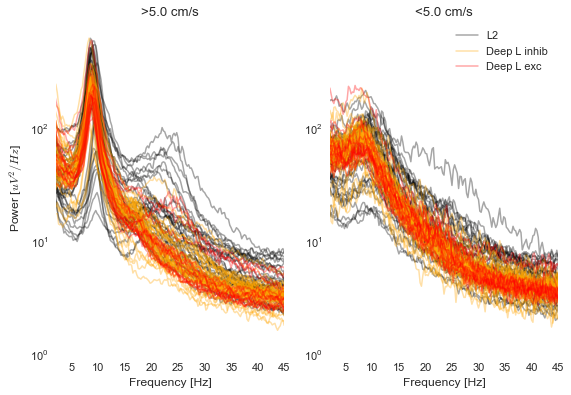

In [35]:
# overlay all psds 
## figure properties:
sns.set()
sns.set(font_scale=1.1)
sns.set_style('white')
figure = plt.figure(figsize=(9,6))
ax1 = figure.add_subplot(1,2,1)

for no in tqdm_notebook(xrange(len(lfp_sup_inhib_analysis))):
    ax1.semilogy(lfp_sup_inhib_analysis.iloc[no].f_speed,
                 lfp_sup_inhib_analysis.iloc[no].psd_speed,'k',linestyle='-',lw=1.5,alpha=.35)
    #ax1.semilogy(f_slow,psd_slow,'k',alpha=.5, label='< {:.1f} cm/s'.format(speed_cutoff),lw=1.5)

for no in tqdm_notebook(xrange(len(lfp_deep_inhib_analysis))):
    ax1.semilogy(lfp_deep_inhib_analysis.iloc[no].f_speed,
                 lfp_deep_inhib_analysis.iloc[no].psd_speed,'orange',linestyle='-',lw=1.5,alpha=.35)
    #ax1.semilogy(f_slow,psd_slow,'k',alpha=.5, label='< {:.1f} cm/s'.format(speed_cutoff),lw=1.5)

for no in tqdm_notebook(xrange(len(lfp_deep_exc_analysis))):
    ax1.semilogy(lfp_deep_exc_analysis.iloc[no].f_speed,
                 lfp_deep_exc_analysis.iloc[no].psd_speed,'red',linestyle='-',lw=1.5,alpha=.35)
    #ax1.semilogy(f_slow,psd_slow,'k',alpha=.5, label='< {:.1f} cm/s'.format(speed_cutoff),lw=1.5)

ax1.set_title('>{} cm/s'.format(speed_cutoff))
ax1.set_ylabel('Power [$uV^{2}/Hz$]')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_xlim((2,45))
ax1.set_ylim((1,900))

ax2 = figure.add_subplot(1,2,2)

for no in tqdm_notebook(xrange(len(lfp_sup_inhib_analysis))):
    ax2.semilogy(lfp_sup_inhib_analysis.iloc[no].f_speed,
                 lfp_sup_inhib_analysis.iloc[no].psd_slow,'k',linestyle='-',lw=1.5,alpha=.35,label=['L2' if no==0 else ''][0])
    #ax1.semilogy(f_slow,psd_slow,'k',alpha=.5, label='< {:.1f} cm/s'.format(speed_cutoff),lw=1.5)

for no in tqdm_notebook(xrange(len(lfp_deep_inhib_analysis))):
    ax2.semilogy(lfp_deep_inhib_analysis.iloc[no].f_speed,
                 lfp_deep_inhib_analysis.iloc[no].psd_slow,'orange',linestyle='-',lw=1.5,alpha=.35,label=['Deep L inhib' if no==0 else ''][0])
    #ax1.semilogy(f_slow,psd_slow,'k',alpha=.5, label='< {:.1f} cm/s'.format(speed_cutoff),lw=1.5)

for no in tqdm_notebook(xrange(len(lfp_deep_exc_analysis))):
    ax2.semilogy(lfp_deep_exc_analysis.iloc[no].f_speed,
                 lfp_deep_exc_analysis.iloc[no].psd_slow,'red',linestyle='-',lw=1.5,alpha=.35,label=['Deep L exc' if no==0 else ''][0])
    #ax1.semilogy(f_slow,psd_slow,'k',alpha=.5, label='< {:.1f} cm/s'.format(speed_cutoff),lw=1.5)
ax2.set_xlabel('Frequency [Hz]')
ax2.set_xlim((2,45))
ax2.set_ylim((1,900))
ax2.set_title('<{} cm/s'.format(speed_cutoff))
ax2.legend()

sns.despine(left=True,bottom=True)
plt.show()


**For further analysis concatenate into one big dataset:**
- lfp_sup_inhib_analysis
- lfp_deep_exc_analysis
- lfp_deep_inhib_analysis

-> lfp_combined_analysis

In [36]:
lfp_combined_analysis = pd.DataFrame()

label = {0: 'L2'}
lfp_sup_inhib_analysis['label_session'] = np.zeros((len(lfp_sup_inhib_analysis))) 
lfp_sup_inhib_analysis['label_session'] = lfp_sup_inhib_analysis['label_session'].map(label)

label = {0: 'Deep L exc'}
lfp_deep_exc_analysis['label_session'] = np.zeros((len(lfp_deep_exc_analysis))) 
lfp_deep_exc_analysis['label_session'] = lfp_deep_exc_analysis['label_session'].map(label)

label = {0: 'Deep L inhib'}
lfp_deep_inhib_analysis['label_session'] = np.zeros((len(lfp_deep_inhib_analysis))) 
lfp_deep_inhib_analysis['label_session'] = lfp_deep_inhib_analysis['label_session'].map(label)

# combine
lfp_combined_analysis = pd.concat([lfp_sup_inhib_analysis,lfp_deep_exc_analysis,lfp_deep_inhib_analysis])

### plot power bar plot 

In [37]:
lfp_combined_analysis.columns   # theta_peak_pow_speed

Index([u'f_speed', u'psd_speed', u'theta_peak_freq_speed',
       u'theta_peak_pow_speed', u'f_slow', u'psd_slow',
       u'theta_peak_freq_slow', u'theta_peak_pow_slow', u'rises_speed',
       u'decays_speed', u'ratios_speed', u'rises_slow', u'decays_slow',
       u'ratios_slow', u'label_session'],
      dtype='object')

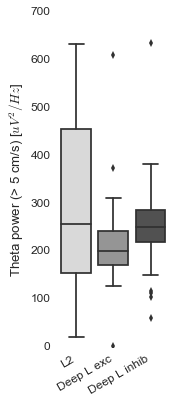

In [38]:
figure = plt.figure(figsize=(2,6))
sns.set(font_scale=1.2)
sns.set_style('white')
counter_fig = 1
ax = figure.add_subplot(1,1,1)
sns.boxplot(x='label_session', y='theta_peak_pow_speed',
     data=lfp_combined_analysis, palette="Greys",ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Theta power (> 5 cm/s) [$uV^{2}/Hz$]')

labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=30,ha='right')

sns.despine(left=True,bottom=True)
figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=0.9)
plt.show()

#### freq bar plot

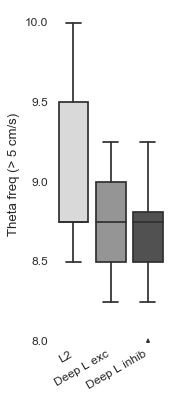

In [39]:
figure = plt.figure(figsize=(2,6))
sns.set(font_scale=1.2)
sns.set_style('white')
counter_fig = 1
ax = figure.add_subplot(1,1,1)
sns.boxplot(x='label_session', y='theta_peak_freq_speed',
     data=lfp_combined_analysis, palette="Greys",ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Theta freq (> 5 cm/s)')
ax.set_ylim((8,10.1))

labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=30,ha='right')

sns.despine(left=True,bottom=True)
figure.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.2, hspace=0.9)
plt.show()

### Analyze rise decay

- lfp_sup_inhib_analysis
- lfp_deep_exc_analysis
- lfp_deep_inhib_analysis

#### lfp_sup_inhib_analysis (L2)

In [40]:
lfp_sup_inhib_rises_speed = [item for sublist in lfp_sup_inhib_analysis.rises_speed.values for item in sublist]
lfp_sup_inhib_decays_speed = [item for sublist in lfp_sup_inhib_analysis.decays_speed.values for item in sublist]
lfp_sup_inhib_ratios_speed = [item for sublist in lfp_sup_inhib_analysis.ratios_speed.values for item in sublist]

lfp_sup_inhib_rises_slow = [item for sublist in lfp_sup_inhib_analysis.rises_slow.values for item in sublist]
lfp_sup_inhib_decays_slow = [item for sublist in lfp_sup_inhib_analysis.decays_slow.values for item in sublist]
lfp_sup_inhib_ratios_slow = [item for sublist in lfp_sup_inhib_analysis.ratios_slow.values for item in sublist]

C:\Users\horsto\AppData\Local\Continuum\Miniconda2\envs\analysis\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


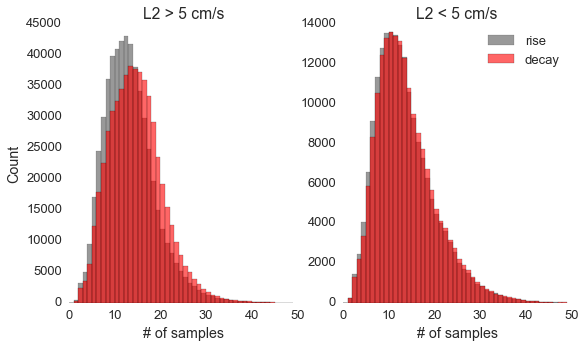

In [41]:
# Plot histograms of rise times, decay times
figure = plt.figure(figsize=(9,5))
sns.set(font_scale=1.3)
sns.set_style('white')
bins=np.arange(0,50,1)

ax = figure.add_subplot(1,2,1)
ax.hist(lfp_sup_inhib_rises_speed,bins,color='k',alpha=.4)
ax.hist(lfp_sup_inhib_decays_speed,bins,color='red',alpha=.6)
ax.set_ylabel('Count')
ax.legend(loc='best')
ax.set_xlabel('# of samples')
ax.set_title('L2 > 5 cm/s')

ax = figure.add_subplot(1,2,2)
ax.hist(lfp_sup_inhib_rises_slow,bins,color='k',label='rise',alpha=.4)
ax.hist(lfp_sup_inhib_decays_slow,bins,color='red',label='decay',alpha=.6)
ax.legend(loc='best')
ax.set_title('L2 < 5 cm/s')
ax.set_xlabel('# of samples')
sns.despine(left=True,bottom=True)

plt.show()

#### lfp_deep_exc_analysis (deep layers)

In [42]:
lfp_deep_exc_rises_speed = [item for sublist in lfp_deep_exc_analysis.rises_speed.values for item in sublist]
lfp_deep_exc_decays_speed = [item for sublist in lfp_deep_exc_analysis.decays_speed.values for item in sublist]
lfp_deep_exc_ratios_speed = [item for sublist in lfp_deep_exc_analysis.ratios_speed.values for item in sublist]

lfp_deep_exc_rises_slow = [item for sublist in lfp_deep_exc_analysis.rises_slow.values for item in sublist]
lfp_deep_exc_decays_slow = [item for sublist in lfp_deep_exc_analysis.decays_slow.values for item in sublist]
lfp_deep_exc_ratios_slow = [item for sublist in lfp_deep_exc_analysis.ratios_slow.values for item in sublist]

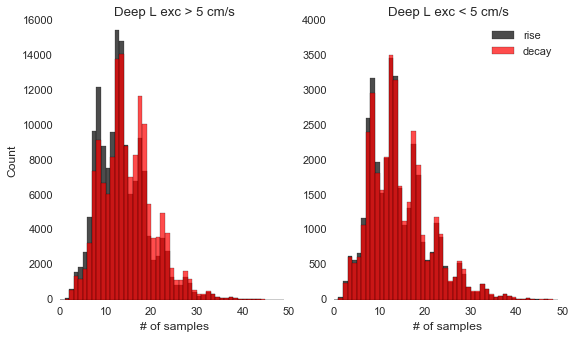

In [43]:
figure = plt.figure(figsize=(9,5))
sns.set(font_scale=1.1)
sns.set_style('white')
bins=np.arange(0,50,1)

ax = figure.add_subplot(1,2,1)
ax.hist(lfp_deep_exc_rises_speed,bins,color='k',alpha=.7)
ax.hist(lfp_deep_exc_decays_speed,bins,color='red',alpha=0.7)
ax.set_ylabel('Count')
ax.legend(loc='best')
ax.set_xlabel('# of samples')
ax.set_title('Deep L exc > 5 cm/s')

ax = figure.add_subplot(1,2,2)
ax.hist(lfp_deep_exc_rises_slow,bins,color='k',label='rise',alpha=.7)
ax.hist(lfp_deep_exc_decays_slow,bins,color='red',label='decay',alpha=0.7)
ax.legend(loc='best')
ax.set_title('Deep L exc < 5 cm/s')
ax.set_xlabel('# of samples')
sns.despine(left=True,bottom=True)

plt.show()

#### lfp_deep_inhib_analysis (deep layers)


In [44]:
lfp_deep_inhib_rises_speed = [item for sublist in lfp_deep_inhib_analysis.rises_speed.values for item in sublist]
lfp_deep_inhib_decays_speed = [item for sublist in lfp_deep_inhib_analysis.decays_speed.values for item in sublist]
lfp_deep_inhib_ratios_speed = [item for sublist in lfp_deep_inhib_analysis.ratios_speed.values for item in sublist]

lfp_deep_inhib_rises_slow = [item for sublist in lfp_deep_inhib_analysis.rises_slow.values for item in sublist]
lfp_deep_inhib_decays_slow = [item for sublist in lfp_deep_inhib_analysis.decays_slow.values for item in sublist]
lfp_deep_inhib_ratios_slow = [item for sublist in lfp_deep_inhib_analysis.ratios_slow.values for item in sublist]

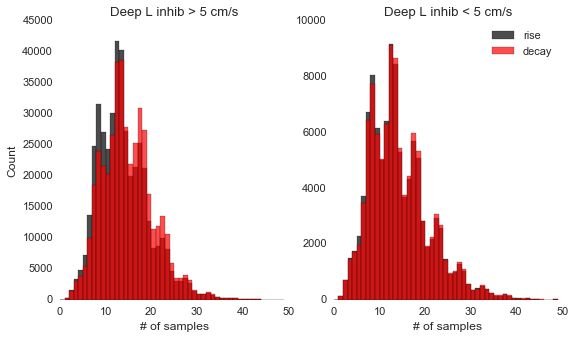

In [45]:
figure = plt.figure(figsize=(9,5))
sns.set(font_scale=1.1)
sns.set_style('white')
bins=np.arange(0,50,1)

ax = figure.add_subplot(1,2,1)
ax.hist(lfp_deep_inhib_rises_speed,bins,color='k',alpha=.7)
ax.hist(lfp_deep_inhib_decays_speed,bins,color='red',alpha=0.7)
ax.set_ylabel('Count')
ax.legend(loc='best')
ax.set_xlabel('# of samples')
ax.set_title('Deep L inhib > 5 cm/s')

ax = figure.add_subplot(1,2,2)
ax.hist(lfp_deep_inhib_rises_slow,bins,color='k',label='rise',alpha=.7)
ax.hist(lfp_deep_inhib_decays_slow,bins,color='red',label='decay',alpha=0.7)
ax.legend(loc='best')
ax.set_title('Deep L inhib < 5 cm/s')
ax.set_xlabel('# of samples')
sns.despine(left=True,bottom=True)

plt.show()

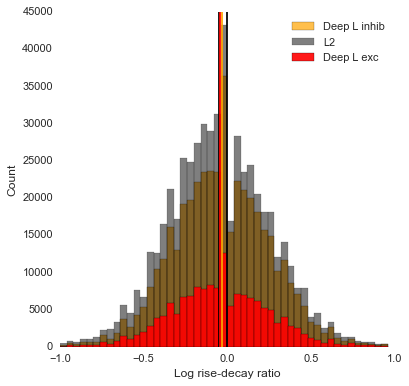

In [46]:
# plot ratios log 10
ratios_speed_sup_inhib= np.log10(lfp_sup_inhib_ratios_speed)
ratios_speed_deep_inhib= np.log10(lfp_deep_inhib_ratios_speed)
ratios_speed_deep_exc = np.log10(lfp_deep_exc_ratios_speed)

# Plot histogram of ratios
# We see that this distribution is skewed negative, indicating that the decay is longer than the rise
bins=np.arange(-1,1,.04)
plt.figure(figsize=(6,6))
plt.hist(ratios_speed_deep_inhib,bins,color='orange',alpha=0.7,range=(bins.min(),bins.max()),label='Deep L inhib')
plt.axvline(x=np.mean(ratios_speed_deep_inhib),color='orange',alpha=1)
plt.hist(ratios_speed_sup_inhib,bins,color='k',alpha=0.5,range=(bins.min(),bins.max()),label='L2')
plt.axvline(x=np.mean(ratios_speed_sup_inhib),color='k',alpha=1)
plt.hist(ratios_speed_deep_exc,bins,color='r',alpha=0.9,range=(bins.min(),bins.max()),label='Deep L exc')
plt.axvline(x=np.mean(ratios_speed_deep_exc),color='r',alpha=1)

plt.axvline(x=0, color='k')
plt.ylabel('Count')
plt.legend()
plt.xlabel('Log rise-decay ratio')
sns.despine(left=True,bottom=True)
plt.show()